In [162]:
import numpy as np
import networkx as nx

# Un-biased random walk for `DeepWalk`
## Return values and parameters of the Random walk class
- `adj_mat` : Get the adjacency matrix of the network.
- `walk_len` : Get the length of random walk to generate.
- `start_node` : Get the starting point for the random walk.
- `final_walk` : Return the walk as a list of integers.

## Algorithm
- Start a dfs from the `start_node` node.
- With uniform probability pick a neighbour to go in the next step of the `dfs`.
- Continue for `walk_len` steps.

In [163]:
def unbiased_random_walk(
                adj_mat : 'list[list[int]]', 
                walk_len : 'int', 
                start_node : 'int'
        ) -> np.array:
        """
        Returns a random walk of length walk_len from start_node in the graph.

        Parameters
        ----------
        adj_mat : list[list[int]]
                Adjacency matrix of the graph.
        walk_len : int
                Length of the random walk.
        start_node : int
                Starting node of the random walk.

        Returns
        -------
        np.array
                List of nodes in the random walk.        
        """
        # Array to store the walk
        walk = [start_node]

        # Make an adjacency matrix to easily 
        # sample the neighbors of a node.
        adj_list = []
        for i in range(len(adj_mat)):
                # This line was autocompleted by GH Copilot
                adj_list.append(np.where(adj_mat[i] > 0)[0])

        # Keep walking for walk_len epochs
        for epochs in range(walk_len):
                # Randomly pick a node from the adj_list[walk[-1]] 
                # and append it to the walk
                walk.append(np.random.choice(adj_list[walk[-1]]))

        return np.array(walk)

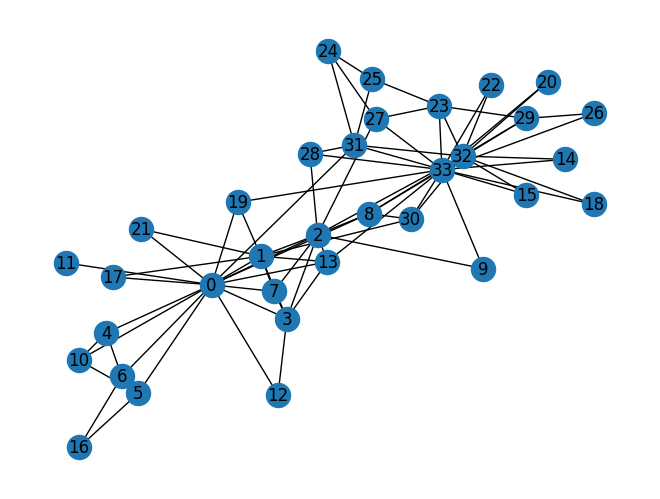

In [164]:
# Get the karate graph
G = nx.karate_club_graph()

# Print the G
nx.draw(G, with_labels=True)

In [165]:
# Print a random walk
print(unbiased_random_walk(nx.adjacency_matrix(G).todense(), 10, 3))

[ 3  1  7  0 21  0  2  3  0 10  5]


# $2^{nd}$ order biased Random Walk for `node2vec`
## Return values and parameters of the function
- `adj_mat` : Get the adjacency matrix of the network.
- `walk_len` : Get the length of random walk to generate.
- `start_node` : Get the starting point for the random walk.
- `final_walk` : Return the walk as a list of integers.
- `return_parameter` : `p` in the `node2vec` paper.
- `in_out_parameter` : `q` in the `node2vec` paper.

In [166]:
def second_order_biased_random_walk(
                adj_mat : 'list[list[int]]', 
                walk_len : 'int', 
                start_node : 'int', 
                return_parameter :'float', 
                in_out_parameter : 'float'
                ) -> np.array:
        """
        Return a walk based on a 2nd order Markov Chain like transition.

        Parameters
        ----------
        adj_mat : list[list[int]]
                Adjacency matrix of the graph.
        walk_len : int
                Length of the random walk.
        start_node : int
                Starting node of the random walk.
        return_parameter : float
                The value of the "p" parameter
        in_out_parameter : float
                The value of the "q" parameter
        
        Returns
        -------
        np.array
                List of nodes in the random walk.  
        
        """
        # Array to store the walk
        walk = [
                start_node, # Extra node to help uniformly sample the second node
                start_node # The actual walk we will return is walk
        ]

        # Make an adjacency list to easily 
        # sample the neighbors of a node.
        adj_list = [] # list of [node, weight]
        for i in range(len(adj_mat)):
                neighbors = np.where(adj_mat[i] > 0)[0]  # Get neighbor indices
                weights = adj_mat[i, neighbors]  # Get corresponding edge weights
                adj_list.append(list(zip(neighbors, weights)))

        # Keep walking for walk_len epochs
        for epochs in range(walk_len):
                # 1) Assign a value of 1 / in_out 
                #    to all neighbours of walk[-1]
                # 2) Overwrite the value of all 
                #    neighbours of walk[-2] with 1 
                # 3) Overwrite walk[-2] by 1
                # 4) Multiply each element by the 
                #    weight of the corresponding edge. 
                # Feed it to np.random.choice

                # Current and Parent node 
                curr_node = walk[-1]
                prev_node = walk[-2]

                # Using the parent_node id get the neighbours and their weights
                neighbors, weights = zip(*adj_list[curr_node])
                prev_neighbors, prev_weights = zip(*adj_list[prev_node])

                # Get boolean arrays to mark current neighbours as previous node's neighbours
                is_prev_neighbor = np.isin(neighbors, prev_neighbors)
                is_prev_node = np.isin(prev_node, neighbors)
                
                # Calculate probabilities based on the return and in-out parameters
                probabilities = np.zeros(len(neighbors), dtype=np.float64)
                
                probabilities[is_prev_node] = 1.0 / return_parameter
                probabilities[is_prev_neighbor] = 1.0
                probabilities[~(is_prev_node | is_prev_neighbor)] = 1.0 / in_out_parameter

                # Normalize the probabilities
                probabilities /= np.sum(probabilities)

                # Multiply each element by the weight of the corresponding edge
                weighted_probabilities = probabilities * weights

                # Choose the next node based on the probabilities
                next_node = np.random.choice(neighbors, p=weighted_probabilities / np.sum(weighted_probabilities))

                walk.append(next_node)


        return np.array(walk[1:])

In [167]:
# Print a random walk
print(second_order_biased_random_walk(nx.adjacency_matrix(G).todense(), 10, 3, 4, 1))

[ 3 13  0  2  1  0 21  1  7  3 13]
